In [1]:
import re
from queue import Queue
from typing import Iterable
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ete3
from ete3 import PhyloTree
from scipy.stats import entropy

from Bio.Data import CodonTable

In [35]:
path_to_tree =   "../data/interim/iqtree_runs/brun3/anc_kg.treefile"
path_to_states = "../data/interim/iqtree_runs/brun3/anc_kg.state"
path_to_leaves = "../data/interim/leaves_birds_states.tsv"

In [34]:
!ls ../data/interim/iqtree_runs/brun3/

aln		 ND5.fna
anc		 phylo.best_model.nex
anc_kg.ckp.gz	 phylo.best_scheme
anc_kg.iqtree	 phylo.best_scheme.nex
anc_kg.log	 phylo.ckp.gz
anc_kg.state	 phylo_ex_constraint.best_model.nex
anc_kg.treefile  phylo_ex_constraint.bionj
anc_only	 phylo_ex_constraint.ckp.gz
ATP6.fna	 phylo_ex_constraint.iqtree
ATP8.fna	 phylo_ex_constraint.log
both.tree	 phylo_ex_constraint.mldist
constraint.tre	 phylo_ex_constraint.treefile
COX1.fna	 phylo.iqtree
COX2.fna	 phylo.log
COX3.fna	 phylo.model.gz
CYTB.fna	 phylo.parstree
mf.ckp.gz	 phylo.treefile
mf.iqtree	 scheme_birds_max_anc.nex
mf.log		 scheme_birds_max.nex
mf.model.gz	 test.log
mf.parstree	 topology.best_model.nex
mf.treefile	 topology.ckp.gz
ND1.fna		 topology.iqtree
ND2.fna		 topology.log
ND3.fna		 topology.treefile
ND4.fna		 topology.trees
ND4L.fna


In [36]:
tree = tree = PhyloTree(path_to_tree, format=1)

In [37]:
tree.describe()

Number of leaf nodes:	764
Total number of nodes:	1526
Rooted:	No
Most distant node:	Crypturellus_undulatus
Max. distance:	0.447375


In [6]:
# print(tree.get_ascii())
# tree.show()

In [83]:
adtype = {
    "Site": np.int32,
    "p_A":  np.float32,
    "p_C":  np.float32,
    "p_G":  np.float32,
    "p_T":  np.float32
}
anc = pd.read_csv(path_to_states, sep="\t", comment='#', dtype=adtype)
leaves = pd.read_csv(path_to_leaves, sep="\t", dtype=adtype)


In [84]:
leaves.head(2)

,Node,Part,Site,State,p_A,p_C,p_G,p_T
0,Acanthisitta_chloris,1,1,-,0.0,0.0,0.0,0.0
1,Acanthisitta_chloris,1,2,-,0.0,0.0,0.0,0.0


## Adapt anc table (part adding & site replacement)

In [85]:
anc.head(2)

,Node,Site,State,p_A,p_C,p_G,p_T
0,Node10,1,A,0.85841,0.03976,0.07306,0.02876
1,Node10,2,T,0.03453,0.18599,0.01500,0.76448


In [86]:
one_leaf = leaves[leaves.Node == leaves.Node.sample().values[0]].sort_values(["Part", "Site"])

In [87]:
one_leaf

,Node,Part,Site,State,p_A,p_C,p_G,p_T
19035,Philesturnus_carunculatus,1,1,-,0.0,0.0,0.0,0.0
19036,Philesturnus_carunculatus,1,2,-,0.0,0.0,0.0,0.0
19037,Philesturnus_carunculatus,1,3,-,0.0,0.0,0.0,0.0
19038,Philesturnus_carunculatus,1,4,-,0.0,0.0,0.0,0.0
19039,Philesturnus_carunculatus,1,5,-,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
8535007,Philesturnus_carunculatus,12,1916,-,0.0,0.0,0.0,0.0
8535008,Philesturnus_carunculatus,12,1917,-,0.0,0.0,0.0,0.0
8535009,Philesturnus_carunculatus,12,1918,-,0.0,0.0,0.0,0.0
8535010,Philesturnus_carunculatus,12,1919,-,0.0,0.0,0.0,0.0


In [106]:
replication_factor = anc.shape[0] / one_leaf.shape[0]
assert replication_factor == int(replication_factor)
replication_factor = int(replication_factor)
replication_factor

762

In [89]:
anc = anc.sort_values(["Node", "Site"])

In [90]:
anc.head()

,Node,Site,State,p_A,p_C,p_G,p_T
8618325,Node1,1,A,0.96190,0.00923,0.02219,0.00668
8618326,Node1,2,T,0.00800,0.05699,0.00347,0.93154
8618327,Node1,3,G,0.04505,0.00893,0.93955,0.00646
8618328,Node1,4,A,0.99358,0.00052,0.00553,0.00037
8618329,Node1,5,A,0.83463,0.03430,0.01926,0.11182


In [107]:
np.tile(one_leaf.Site.values, replication_factor)

array([   1,    2,    3, ..., 1918, 1919, 1920], dtype=int32)

In [108]:
anc["Part"] = np.tile(one_leaf.Part.values, replication_factor)
anc["Site"] = np.tile(one_leaf.Site.values, replication_factor)
anc.head()

,Node,Site,State,p_A,p_C,p_G,p_T,Part
8618325,Node1,1,A,0.96190,0.00923,0.02219,0.00668,1
8618326,Node1,2,T,0.00800,0.05699,0.00347,0.93154,1
8618327,Node1,3,G,0.04505,0.00893,0.93955,0.00646,1
8618328,Node1,4,A,0.99358,0.00052,0.00553,0.00037,1
8618329,Node1,5,A,0.83463,0.03430,0.01926,0.11182,1


In [109]:
leaves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8652300 entries, 0 to 8652299
Data columns (total 8 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Node    object 
 1   Part    int64  
 2   Site    int32  
 3   State   object 
 4   p_A     float32
 5   p_C     float32
 6   p_G     float32
 7   p_T     float32
dtypes: float32(4), int32(1), int64(1), object(2)
memory usage: 363.1+ MB


In [112]:
anc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8629650 entries, 8618325 to 872024
Data columns (total 8 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Node    object 
 1   Site    int32  
 2   State   object 
 3   p_A     float32
 4   p_C     float32
 5   p_G     float32
 6   p_T     float32
 7   Part    int64  
dtypes: float32(4), int32(1), int64(1), object(2)
memory usage: 428.0+ MB


In [113]:
anc.Node.str.startswith("Node").sum() == anc.shape[0]

True

In [124]:
anc.to_csv("../data/interim/anc_kg_states_birds.tsv", sep="\t", index=None)

In [114]:
states = pd.concat([anc, leaves]).sort_values(["Node", "Part", "Site"])
print(states.shape)
states.head()

(17281950, 8)


,Node,Site,State,p_A,p_C,p_G,p_T,Part
0,Acanthisitta_chloris,1,-,0.0,0.0,0.0,0.0,1
1,Acanthisitta_chloris,2,-,0.0,0.0,0.0,0.0,1
2,Acanthisitta_chloris,3,-,0.0,0.0,0.0,0.0,1
3,Acanthisitta_chloris,4,-,0.0,0.0,0.0,0.0,1
4,Acanthisitta_chloris,5,-,0.0,0.0,0.0,0.0,1


In [115]:
states.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17281950 entries, 0 to 8362211
Data columns (total 8 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Node    object 
 1   Site    int32  
 2   State   object 
 3   p_A     float32
 4   p_C     float32
 5   p_G     float32
 6   p_T     float32
 7   Part    int64  
dtypes: float32(4), int32(1), int64(1), object(2)
memory usage: 857.0+ MB


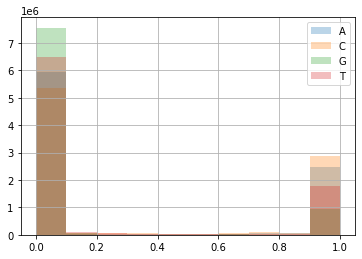

In [116]:
anc.p_A.hist(alpha=.3, label="A")
anc.p_C.hist(alpha=.3, label="C")
anc.p_G.hist(alpha=.3, label="G")
anc.p_T.hist(alpha=.3, label="T")
plt.legend()

## 10% of positions are uncertain

In [117]:
np.any(anc[["p_A", "p_C", "p_G", "p_T"]] > 0.8, 1).value_counts(normalize=True)

True     0.953422
False    0.046578
dtype: float64

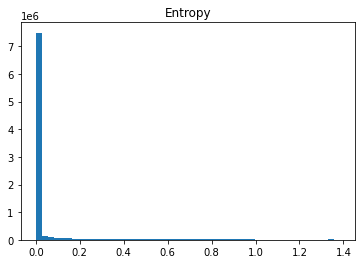

In [120]:
mentr = entropy(anc[["p_A", "p_C", "p_G", "p_T"]].values, axis=1)
plt.hist(mentr, bins=50)
plt.title("Entropy");

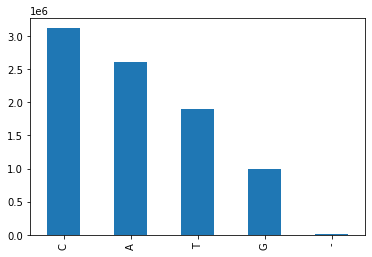

In [121]:
anc.State.value_counts().plot.bar();

## MUTSPEC

In [2]:
label = "birds_24-03-22-20-56-51"

In [4]:
mutations = pd.read_csv(f"../data/processed/{label}/mutations.csv")
edge_mutspec12_all = pd.read_csv(f"../data/processed/{label}/mutspec12_all.csv")
# edge_mutspec_syn = pd.read_csv(f"../data/processed/{label}_mutspec_syn.csv")
edge_mutspec12_ff = pd.read_csv(f"../data/processed/{label}/mutspec12_ff.csv")

edge_mutspec192_all = pd.read_csv(f"../data/processed/{label}/mutspec192_all.csv")
# edge_mutspec_syn = pd.read_csv(f"../data/processed/{label}_mutspec_syn.csv")
edge_mutspec192_ff = pd.read_csv(f"../data/processed/{label}/mutspec192_ff.csv")

In [5]:
translator = str.maketrans("ACGT", "TGCA")
translator

{65: 84, 67: 71, 71: 67, 84: 65}

**We need to get reverse-complecent mutations**

Because:
- genes are on light strand
- usually we look at heavy strand mutspec

<img src="https://els-jbs-prod-cdn.jbs.elsevierhealth.com/cms/attachment/73933a0c-f41b-44c4-8dae-04d383bfba91/gr1.jpg">

In [ ]:
def rev_comp(mut: str):
    

In [17]:
# mutations["Mut"] = mutations["Mut"].str.translate(translator)
# mutations["MutExt"] = mutations["MutExt"].str.translate(translator)
edge_mutspec12_ff["Mut"] = edge_mutspec12_ff["Mut"].str.translate(translator)
edge_mutspec12_all["Mut"] = edge_mutspec12_all["Mut"].str.translate(translator)

# TODO 192

In [18]:
mutations.head(3)

,RefNode,AltNode,Mut,MutExt,Context,RefNucl,AltNucl,Label,Pos,PosInCodon,RefCodon,AltCodon,RefAa,AltAa
0,Node1,Acanthisitta_chloris,A>T,A[A>T]C,AAC,A,T,0,17,2,AAC,ATC,N,I
1,Node1,Acanthisitta_chloris,C>T,T[C>T]G,TCG,C,T,1,30,3,TTC,TTT,F,F
2,Node1,Acanthisitta_chloris,C>T,T[C>T]C,TCC,C,T,1,63,3,ATC,ATT,I,I


In [19]:
edge_mutspec12_ff.head(2)

,Mut,ObsFr,Divisor,RawMutSpec,MutSpec,RefNode,AltNode
0,C>T,126,1034,0.121857,0.106478,Node1,Acanthisitta_chloris
1,A>C,126,1069,0.117867,0.102992,Node1,Acanthisitta_chloris


In [20]:
edge_mutspec192_ff.head(2)

,Mut,ObsFr,Divisor,RawMutSpec,MutSpec,RefNode,AltNode
0,C[C>T]C,25,270,0.092593,0.008328,Node1,Acanthisitta_chloris
1,C[C>T]A,24,199,0.120603,0.010848,Node1,Acanthisitta_chloris


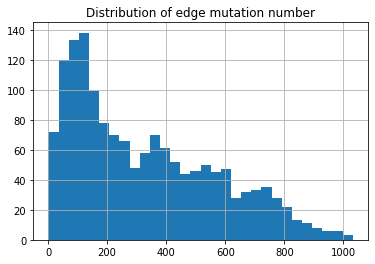

In [7]:
mutations.groupby("AltNode").apply(len).hist(bins=30)
plt.title("Distribution of edge mutation number");

**12 component MutSpec**

In [7]:
# sns.barplot(x="Mut", y="RawMutSpec", data=edge_mutspec_syn, order=sorted(edge_mutspec_syn.Mut.unique()));
# plt.title("Synonymous mutational spectra")
# plt.savefig(f"../figures/{label}_mutspec_syn.svg")
# plt.show()

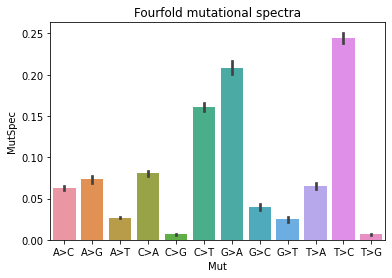

In [57]:
sns.barplot(x="Mut", y="MutSpec", data=edge_mutspec12_ff, order=sorted(edge_mutspec12_ff.Mut.unique()));
plt.title("Fourfold mutational spectra")
plt.savefig(f"../figures/{label}_mutspec12_ff.svg")
plt.show()

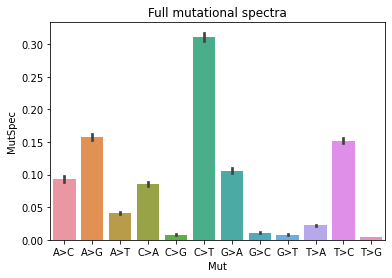

In [58]:
sns.barplot(x="Mut", y="MutSpec", data=edge_mutspec12_all, order=sorted(edge_mutspec12_all.Mut.unique()));
plt.title("Full mutational spectra")
plt.savefig(f"../figures/{label}_mutspec12_all.svg")
plt.show()

**192 component MutSpec**

TODO change x-axis [link](https://stackoverflow.com/questions/51818724/plot-two-levels-of-x-ticklabels-on-a-pandas-multi-index-dataframe)

In [64]:
tmp_df = pd.DataFrame({"MutExt": edge_mutspec192_ff.Mut.unique()})
tmp_df["Mut"] = tmp_df.MutExt.str.get(2) + ">" + tmp_df.MutExt.str.get(4)
tmp_df["Context"] = tmp_df.MutExt.str.get(0) + tmp_df.MutExt.str.get(2) + tmp_df.MutExt.str.get(-1)
tmp_df.sort_values(["Mut", "Context"], inplace=True)
order192 = tmp_df.MutExt.values

In [67]:
edge_mutspec192_ff["MutBase"] = edge_mutspec192_ff.Mut.str.get(2) + ">" + edge_mutspec192_ff.Mut.str.get(4)

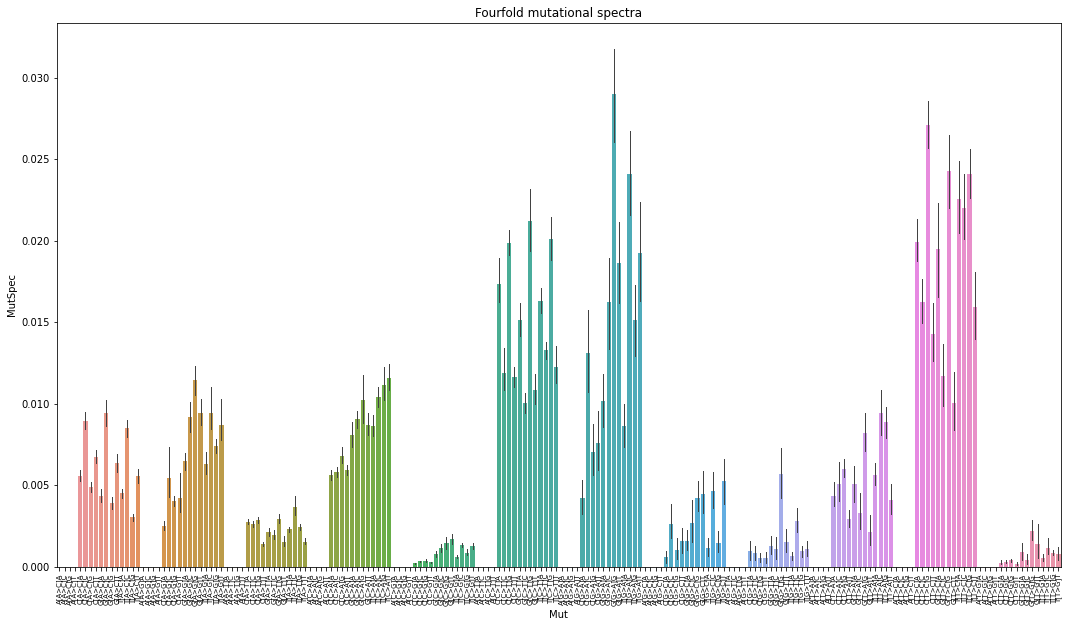

In [72]:
plt.figure(figsize=(18, 10))
sns.barplot(x="Mut", y="MutSpec", data=edge_mutspec192_ff, order=order192, errwidth=1)
plt.title("Fourfold mutational spectra")
plt.xticks(rotation=90, fontsize=7)
plt.savefig(f"../figures/{label}_mutspec192_ff.svg")
plt.show()

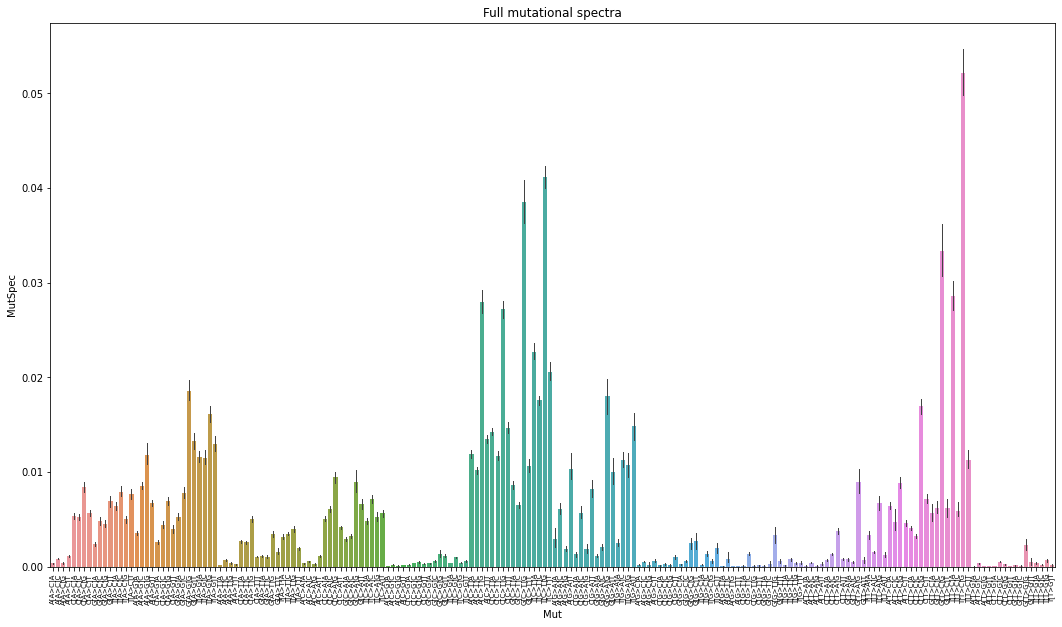

In [61]:
plt.figure(figsize=(18, 10))
sns.barplot(x="Mut", y="MutSpec", data=edge_mutspec192_all, order=order192, errwidth=1)
plt.title("Full mutational spectra")
plt.xticks(rotation=90, fontsize=7)
plt.savefig(f"../figures/{label}_mutspec192_all.svg")
plt.show()

In [14]:
def prepare_one_mut_share_file(mutspec: pd.DataFrame, filename: str, sbs="C>T"):
    assert bool(re.match("[ACGT]>[ACGT]", sbs)), "sbs is not appropriate"
    cols = ["RefNode", "AltNode", "MutSpec"]
    for c in cols:
        assert c in mutspec, f"Column {c} is not in mutspec dataframe"
    
    shares = mutspec[mutspec.Mut == sbs][cols]
    shares.to_csv(filename, "\t", index=None)
    return shares


In [27]:
pref_sbs = "C>T"
prepare_one_mut_share_file(edge_mutspec, "../data/processed/c2t_edge_mutspec.tsv")

<AxesSubplot:>

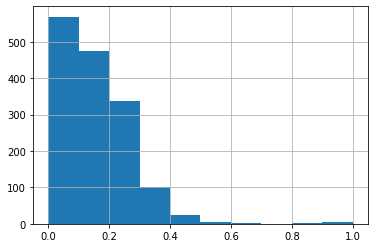

In [11]:
edge_mutspec_ff[edge_mutspec_ff.Mut == "A>G"]["MutSpec"].hist()